In [1]:
# import statements
import glob
import numpy as np 
import cv2
import pdb 
import time
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree
import sys 
import matplotlib.pyplot as plt

In [2]:
def read_images(img_dir):
    # read files in directory and add image to list
    all_images = []
    if not img_dir.endswith("/"):
        img_dir = img_dir + "/"
    filenames = glob.glob(img_dir + "*.jpg")
    tmp_file = filenames[0]
    tmp_img = cv2.imread(tmp_file)
    img_shape = tmp_img.shape
    data_matrix = np.empty((500, img_shape[0]*img_shape[1]*img_shape[2]))
    count = 0
    for file in filenames[0:500]:
        tmp_img = cv2.imread(file)
        all_images.append(tmp_img)
        

        reshaped_img = tmp_img.flatten()
        data_matrix[count, :] = reshaped_img
        count = count + 1
    
    
    return all_images, data_matrix
        
def create_data_matrix(images):
    # reshape each matrix and add to array 
    data_matrix = []
    for image in images: 
        tmp_image = image.flatten()[np.newaxis, :]
        data_matrix.append(tmp_image)
        
        
    data_matrix = np.concatenate(data_matrix, axis=0)
    return data_matrix

def get_closest_face(data_matrix, query_face):
    # data_matrix : matrix of all images, after transformed using directions of maximal variation
    # query_face : vector of query image, after transformed using directions of maximal variation
    # returns index of closest face in data set
    kdt = KDTree(data_matrix, leaf_size=30, metric='euclidean')
    idx = kdt.query(query_face, k=1, return_distance=False) 

    return idx

In [3]:
IMG_DIR =  '../data/img_align_celeba/'
N_EIGEN_FACES = 15
MAX_SLIDER_VALUE = 255

all_images, data_matrix = read_images(IMG_DIR)
IMG_SHAPE = all_images[0].shape


# do PCA analysis
print("Doing PCA analysis ...")
start_time = time.time()


pca = PCA(n_components=N_EIGEN_FACES)  

pca.fit(data_matrix)


# get pca mean 
mean = pca.mean_


eigenvectors = pca.components_.tolist()

# we'll process this list for you
eigenvectors = [np.asarray(eigenvectors[i]) for i in range(len(eigenvectors))]
end_time = time.time()
print("Done!")
print("Duration: ", end_time - start_time)

mean_face = mean.reshape(IMG_SHAPE)
mean_face = np.asarray(mean_face, dtype=np.uint8)

slider_values = []
eigen_faces = []
for eigenvector in eigenvectors:

    tmp_face = eigenvector.reshape(IMG_SHAPE)
    eigen_faces.append(tmp_face)

def make_face(*args):
    new_face = mean_face
    for i in range(N_EIGEN_FACES):
        slider_values[i] = cv2.getTrackbarPos("Weight" + str(i), "Trackbars")
        weight = slider_values[i] - MAX_SLIDER_VALUE/2
        new_face = new_face + eigen_faces[i]*weight*100
        new_face = np.maximum(np.minimum(new_face, 255),0)
        new_face = np.asarray(new_face, dtype=np.uint8)


    new_face = cv2.resize(new_face, (0,0), fx=2, fy=2)

    cv2.imshow("Demo face", new_face)

Doing PCA analysis ...
Done!
Duration:  3.6811766624450684


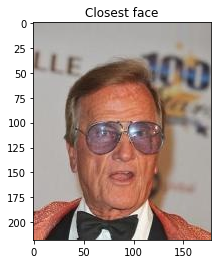

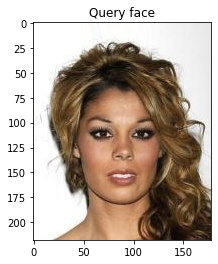

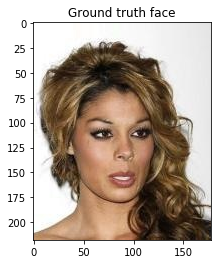

In [4]:
# Example 1
query_filename =  IMG_DIR + '../query_images/013478.jpg'
ground_truth_filename = IMG_DIR + '000006.jpg'

# Example 2
# query_filename = IMG_DIR +  '../query_images/016774.jpg'
# ground_truth_filename = IMG_DIR + '000016.jpg'

# Example 3
# query_filename = IMG_DIR + '../query_images/017423.jpg'
# ground_truth_filename = IMG_DIR + '000033.jpg'

# # Example 4
# query_filename = IMG_DIR + '../query_images/006458.jpg'
# ground_truth_filename = IMG_DIR + '000038.jpg'

query_face_in = cv2.imread(query_filename)  # image as 2D matrix
pca_data_matrix = pca.transform(data_matrix) # only here to provide a baseline, no need to worry about this
# 
# You complete this ------------------------------------------------------------------->
# transform query image to become alpha_tilde(query_face_in.flatten)
# DO NOT use pca.transform, that would be considered cheating !!!!
# in previous cell variable called mean provides the mean of the data points for you
# in previous cell, variable eigenvectors is a list of the eigenvectors of directions of maximal variation
# query_face = alpha_tilde(query_face_in.flatten) ??
# import pdb
"""Turn this into a function..."""
l = len(pca.components_) #15
directions = pca.components_
query_face = np.zeros((l,1))
in_mean = np.mean(query_face_in.flatten())
for i in range(l-14):
    query_face[i,:] = (query_face_in.flatten().T - in_mean).dot(directions[i,:])

# pdb.set_trace()

# get_closest_face will find the closest face in the dataset given your transformed query
result_idx = get_closest_face(pca_data_matrix, query_face.reshape(1, -1))
result_face = np.asarray((data_matrix[result_idx, :]).reshape(IMG_SHAPE), dtype=np.uint8)

ground_truth_face = cv2.imread(ground_truth_filename)


plt.imshow(cv2.cvtColor(result_face, cv2.COLOR_BGR2RGB))
plt.title("Closest face")
plt.show()

plt.imshow(cv2.cvtColor(query_face_in, cv2.COLOR_BGR2RGB))
plt.title("Query face")
plt.show()

plt.imshow(cv2.cvtColor(ground_truth_face, cv2.COLOR_BGR2RGB))
plt.title("Ground truth face")
plt.show()